<a href="https://colab.research.google.com/github/sb24ragnar/HearHealthPredictor/blob/main/Heart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install shap

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import shap

In [3]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
    'oldpeak', 'slope', 'ca', 'thal', 'target'
]

try:
    heart_df = pd.read_csv(url, names=columns)
    print("✅ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()


✅ Dataset loaded successfully!


In [5]:
heart_df.head(25)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


In [6]:
# cleaning
heart_df.replace('?', np.nan, inplace=True)
for col in ['ca', 'thal']:
    heart_df[col] = pd.to_numeric(heart_df[col], errors='coerce')

heart_df.fillna(heart_df.median(), inplace=True)

In [7]:
heart_df.head(20)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


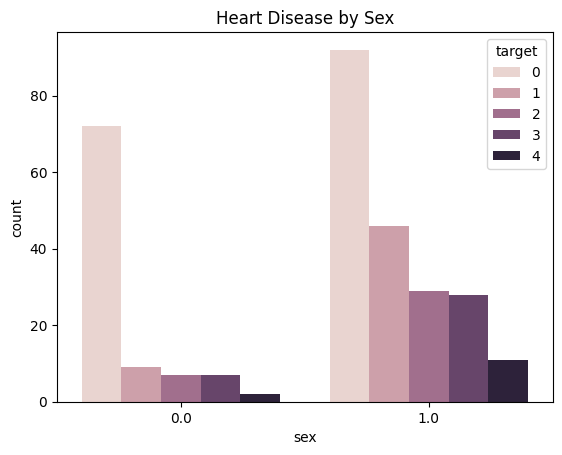

In [8]:
# Sex vs Target
sns.countplot(x='sex', hue='target', data=heart_df)
plt.title('Heart Disease by Sex')
plt.show()

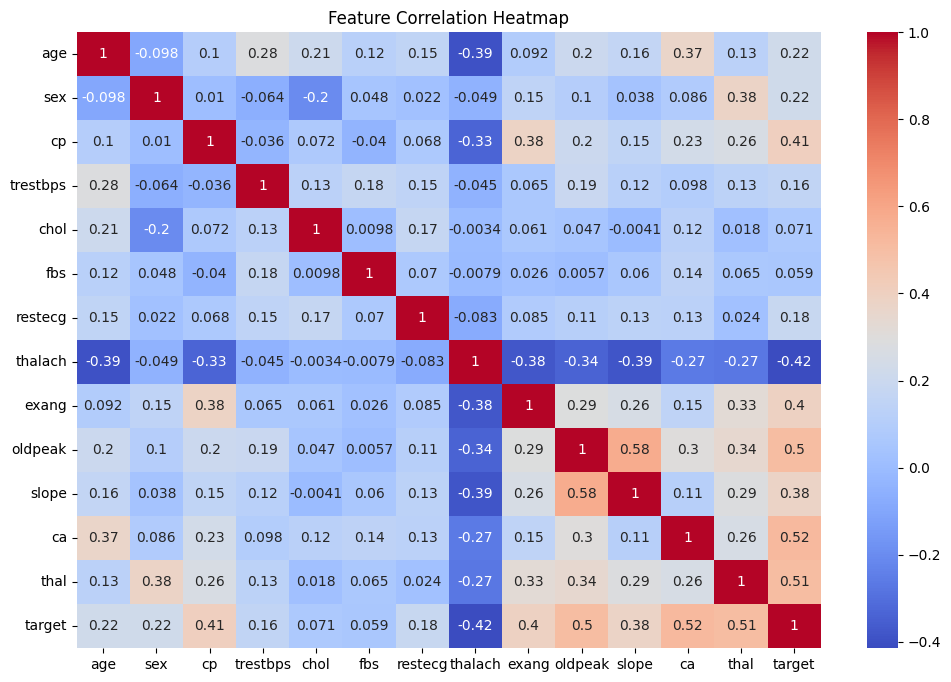

In [9]:
plt.figure(figsize=(12,8))
sns.heatmap(heart_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [10]:
X = heart_df.drop('target', axis=1)
y = heart_df['target']

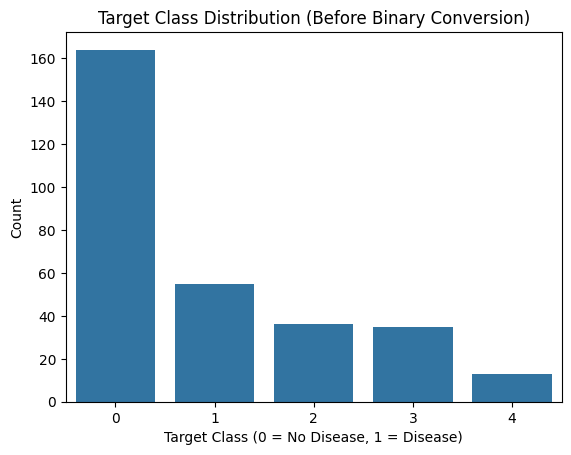

In [11]:
sns.countplot(x=y)
plt.title("Target Class Distribution (Before Binary Conversion)")
plt.xlabel("Target Class (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.show()

In [12]:
feature_columns = [col for col in heart_df.columns if col != 'target']
X = heart_df[feature_columns]  # Features
y = heart_df['target'].apply(lambda x: 1 if x > 0 else 0)

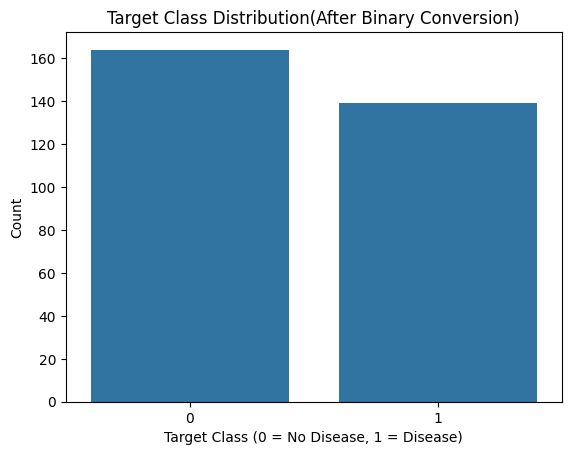

In [13]:
sns.countplot(x=y)
plt.title("Target Class Distribution(After Binary Conversion)")
plt.xlabel("Target Class (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.show()

Before SMOTE:
target
0    164
1    139
Name: count, dtype: int64


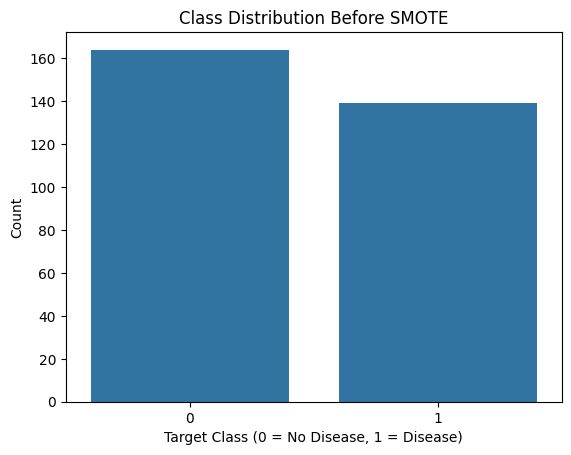

In [14]:


#Class distribution before SMOTE
print("Before SMOTE:")
print(y.value_counts())

sns.countplot(x=y)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Target Class (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.show()



After SMOTE:
target
0    164
1    164
Name: count, dtype: int64


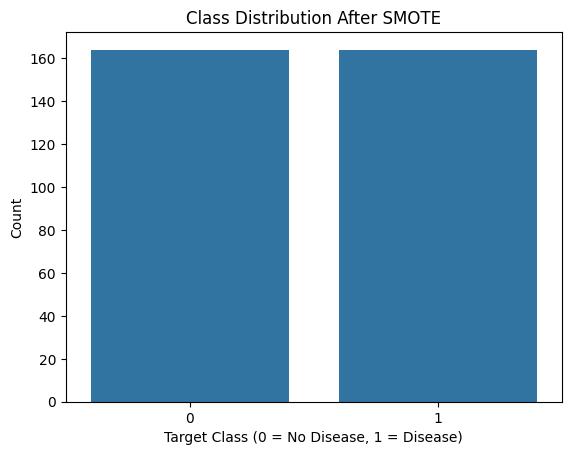

Class 0 count before: 164
Class 1 count before: 139
Class 0 count after: 164
Class 1 count after: 164


In [15]:

# One-Hot Encoding for categorical variables
heart_df = pd.get_dummies(heart_df, columns=['cp', 'restecg', 'slope', 'thal', 'sex'])

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
print("\nAfter SMOTE:")
print(y_balanced.value_counts())

sns.countplot(x=y_balanced)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Target Class (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.show()

print(f"Class 0 count before: {y.value_counts()[0]}")
print(f"Class 1 count before: {y.value_counts()[1]}")
print(f"Class 0 count after: {y_balanced.value_counts()[0]}")
print(f"Class 1 count after: {y_balanced.value_counts()[1]}")

In [16]:
heart_df.head()

,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,cp_1.0,...,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0,sex_0.0,sex_1.0
0,63.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,0,True,...,False,True,False,False,True,False,True,False,False,True
1,67.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,2,False,...,False,True,False,True,False,True,False,False,False,True
2,67.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,1,False,...,False,True,False,True,False,False,False,True,False,True
3,37.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,False,...,False,False,False,False,True,True,False,False,False,True
4,41.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,False,...,False,True,True,False,False,True,False,False,True,False


In [17]:
# Splitting the Data into Training & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

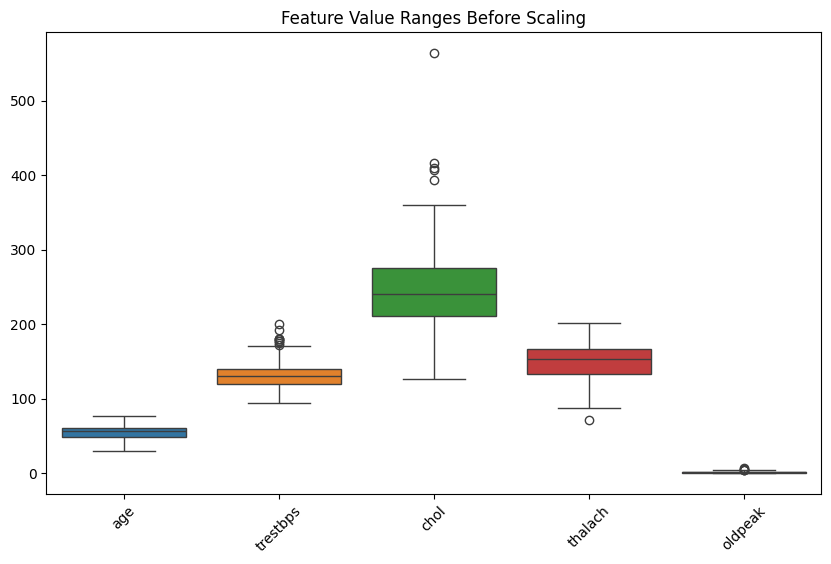

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['age','trestbps','chol','thalach','oldpeak']

plt.figure(figsize=(10,6))
sns.boxplot(data=heart_df[numeric_cols])
plt.title("Feature Value Ranges Before Scaling")
plt.xticks(rotation=45)
plt.show()


In [19]:
#Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scaler file
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

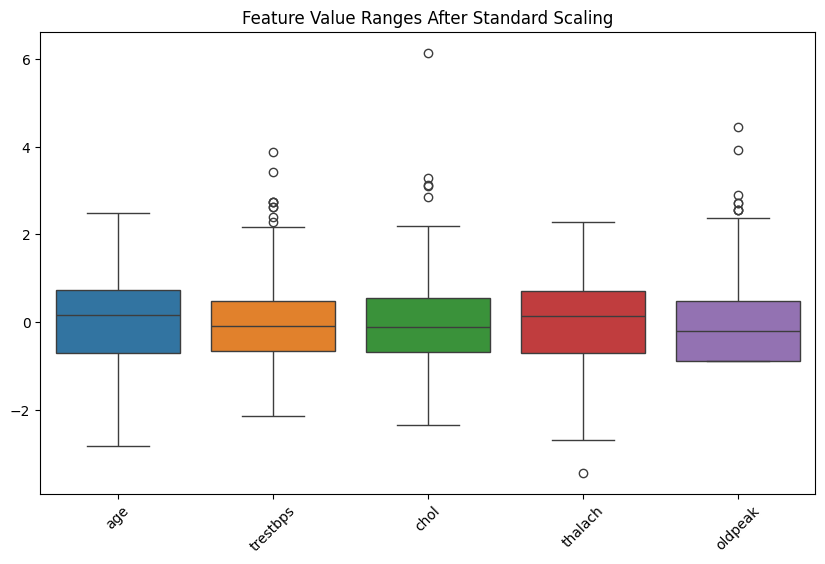

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(heart_df[numeric_cols])
scaled_df = pd.DataFrame(scaled, columns=numeric_cols)

plt.figure(figsize=(10,6))
sns.boxplot(data=scaled_df)
plt.title("Feature Value Ranges After Standard Scaling")
plt.xticks(rotation=45)
plt.show()


In [21]:
# XGBoost hyperparameter tuning
param_grid = {
    "n_estimators": [150, 200, 300],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(
    eval_metric="logloss",
)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    verbose=2,
    n_jobs=-1
)

print("\n🔍 Running hyperparameter tuning...")
grid.fit(X_train_scaled, y_train)
print("----------------------------------------------")
print("\n✅ Best Parameters Found:", grid.best_params_)
xgb_model = grid.best_estimator_



🔍 Running hyperparameter tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
----------------------------------------------

✅ Best Parameters Found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [22]:
print("\n🧠 Generating SHAP explainability...")

shap.initjs()

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)

# Save SHAP components
with open("shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)



🧠 Generating SHAP explainability...


In [23]:
y_pred_xgb = xgb_model.predict(X_test_scaled)
print("\n🔍 XGBoost Model Performance:")
print(classification_report(y_test, y_pred_xgb))
print(f"📊 Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")


🔍 XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        33
           1       0.84      0.82      0.83        33

    accuracy                           0.83        66
   macro avg       0.83      0.83      0.83        66
weighted avg       0.83      0.83      0.83        66

📊 Accuracy: 0.8333


In [25]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=200, verbose=0, random_state=42),
    "XgBoost" : XGBClassifier( n_estimators=200, max_depth=5, learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,eval_metric="logloss")

}

In [26]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "AUC": round(auc, 4) if auc else "-",
        "Precision": round(classification_report(y_test, y_pred, output_dict=True)["1"]["precision"], 4),
        "Recall": round(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"], 4),
        "F1-Score": round(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"], 4)
    })
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
display(results_df)

,Model,Accuracy,AUC,Precision,Recall,F1-Score
1,Random Forest,0.8636,0.9178,0.8529,0.8788,0.8657
4,XgBoost,0.8485,0.8926,0.8286,0.8788,0.8529
3,CatBoost,0.8485,0.9265,0.8485,0.8485,0.8485
2,AdaBoost,0.8333,0.9164,0.8235,0.8485,0.8358
0,Logistic Regression,0.8182,0.9201,0.8182,0.8182,0.8182
